# Plot Flows Matrix

## Import Packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
import seaborn as sns
import string
import pandas as pd

In [2]:
from utilities import *

In [3]:
ROBUST_POLICY_TITLES = {
    'P86': 'Best Low Flow Policy',
    'P72': 'Best High Flow Policy',
    'P41': 'Compromise Policy',
    'PUC': 'Projected Uncontrolled'
}

## Extend Scenarios 

In [4]:
def _get_probs(data, ymin, ymax):
    probMatrix = np.zeros([366,365])
    unscaledMatrix = np.zeros([48*30,365])
    step = (ymax - ymin) / 366
#     for i in range(1,366):
#         values = data[i]
#         x = np.sort(values)
#         y = np.arange(len(x))/float(len(x))
#         probMatrix[:,i] = y
#         unscaledMatrix[:,i] = x
    for i in range(np.shape(probMatrix)[0]):

        for v in range(np.shape(probMatrix)[1]):
            # print(ymax-step*i, ymax-step*(i+1), [f for f in data[v+1] if (f < ymax-step*i) & (f <= ymax=)])
            count = ((np.array(data[v+1]) < ymax-step*i) & (np.array(data[v+1]) >= ymax-step*(i+1))).sum()
            # probMatrix[i,v] = count/100000.0
            probMatrix[i,v] = count/ (48 * 30)
    return probMatrix,unscaledMatrix

In [5]:
class CDF_Flows(Flows):

    def cc_vals(self):
        self.cdf_dict = dict.fromkeys(ROBUST_POLICY_LIST)
        self.full_dataframe = pd.DataFrame()
        for proj in PROJECTIONS:
            self.scenarios[proj]['doy'] = self.scenarios[proj].index.dayofyear
            temp_df = self.scenarios[proj]
            temp_df['projection'] = proj
            self.full_dataframe = pd.concat([self.full_dataframe, temp_df])
                        
        for policy in ROBUST_POLICY_LIST:
            self.cdf_dict[policy] = dict.fromkeys(['cdf', 'flows', 'log'])        
            print(policy)
            doy_dict = dict.fromkeys(range(1,366))
            for doy in doy_dict.keys():
                doy_dict[doy] = []
            for doy in range(1,366):
                df = self.full_dataframe[self.full_dataframe.doy == i]
                val = df[policy].tolist()
                doy_dict[i].extend(val)
            print('   done!')
            
            self.cdf_dict[policy]['cdf'], self.cdf_dict[policy]['flows'] = _get_probs(doy_dict, 0, 12100.0)
            self.cdf_dict[policy]['log'] = np.log10(self.cdf_dict[policy]['cdf'])

In [6]:
flows = CDF_Flows("DailyFlows", 'date', HUC_historical, extremes=False)

In [7]:
flows.cc_vals()

P86
   done!


<ipython-input-5-5448e4b787a4>:25: RuntimeWarning: divide by zero encountered in log10
  self.cdf_dict[policy]['log'] = np.log10(self.cdf_dict[policy]['cdf'])


P72
   done!


<ipython-input-5-5448e4b787a4>:25: RuntimeWarning: divide by zero encountered in log10
  self.cdf_dict[policy]['log'] = np.log10(self.cdf_dict[policy]['cdf'])


P41
   done!


<ipython-input-5-5448e4b787a4>:25: RuntimeWarning: divide by zero encountered in log10
  self.cdf_dict[policy]['log'] = np.log10(self.cdf_dict[policy]['cdf'])


PUC
   done!


<ipython-input-5-5448e4b787a4>:25: RuntimeWarning: divide by zero encountered in log10
  self.cdf_dict[policy]['log'] = np.log10(self.cdf_dict[policy]['cdf'])


## Uncontrolled CDF 

In [8]:
UC_Historical = pd.read_csv('../../../Historical/Timeseries/Uncontrolled/Historical_00_Flow.csv', parse_dates=True, index_col = 'date')
UC_Historical['doy'] = UC_Historical.index.dayofyear

UC_Hist_DOY = dict.fromkeys(range(1,366))

for key in UC_Hist_DOY:
    UC_Hist_DOY[key] = []


for i in range(1,366):
    df = UC_Historical[UC_Historical.doy == i]
    val = df['flow'].tolist()
    UC_Hist_DOY[i].extend(val)
    uc

probMatrix = np.zeros([30,365])
unscaledMatrix = np.zeros([30,365])

for i in range(1,365):
    values = UC_Hist_DOY[i]
    x = np.sort(values)
    y = np.arange(len(x))/float(len(x))
    probMatrix[:,i] = y
    unscaledMatrix[:,i] = x

    
uc_hist = unscaledMatrix.transpose()
cdf_hist = probMatrix.transpose()

# Plot


In [9]:
j = 0
for policy in ['PUC', 'P86', 'P72', 'P41']:
    fill = flows.cdf_dict[policy]['log']
    a = fill[fill > -np.inf]
    if j == 0:
        tickMin = np.min(a)
        tickMax = np.max(a)
    else: 
        tickMin = min(np.min(a), np.min(tickMin))
        tickMax = max(np.max(a), np.max(tickMax))
        
    j+= 1

In [10]:
print(tickMin, tickMax)

-0.5960696276387749 1.8766868216784374


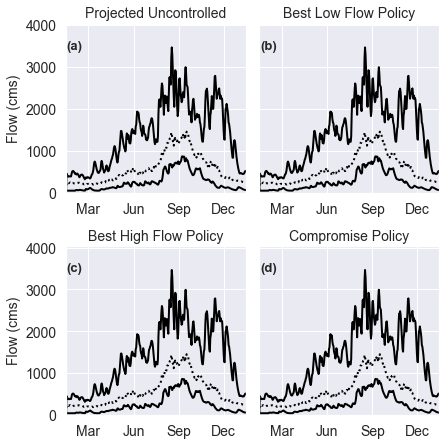

In [11]:
pols = ['PUC', 'P86', 'P72', 'P41']
ncols = 2 # 1st column = best flood soln, 2nd column = best hydro soln, 3rd column = compromise
nrows = 2 # 1st row = WC formulation, 2nd row = WP1 formulation
# titles = ["Uncontrolled", "Most Robust 7QS Policy", "Most Robust AMS Policy", "Most Robust AMS_ENV Policy", "Most Robust Policy for AMS and 7QS"]
sns.set()
fig = plt.figure()
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(nrows,ncols,ncols * i + j + 1)
        sm = ax.imshow(flows.cdf_dict[pols[ncols * i + j]]['log'], cmap='RdYlBu_r',origin="upper", aspect='auto',norm=mpl.colors.Normalize(vmin=tickMin, vmax=tickMax))

        ax.set_xticks([45,137,229,319])
        ax.set_xticklabels(['Mar','Jun','Sep','Dec'],fontsize=14)

        ax.set_ylim(366,244) 
        hist_min = ax.plot((1-uc_hist[:,0]/12100)*(366), color="black", linewidth = 2, label = "HUC Max/Min") # first alarm
        hist_max = ax.plot((1-uc_hist[:,29]/12100)*(366), color="black", linewidth = 2) # first alarm
        hist_med = ax.plot((1-uc_hist[:,14]/12100)*(366), color="black", linewidth = 2, linestyle='dotted', label="HUC Median") # first alarm

        ax.set_yticks(np.arange(245,366+ 245/8,245/8))
        # print(np.arange(12100/2,0-12100/4,-12100/4))
        if (ncols * i + j) % 2 == 0:
            ax.set_yticklabels(np.arange(4000, 0-1000,-1000),fontsize=14)
            ax.set_ylabel("Flow (cms)", fontsize=14)
        else:
            ax.set_yticklabels("")

        ax.text(0.005, 0.85, "("+ string.ascii_lowercase[ncols * i + j] + ")", transform=ax.transAxes, 
            size=13, weight='bold')
        ax.set_title(ROBUST_POLICY_TITLES[pols[ncols * i + j]], fontsize=14)




fig.subplots_adjust(right=0.8,bottom=0.2)
# cbar_ax = fig.add_axes([0.58, 0.72, 0.05, 0.24])
# cbar = fig.colorbar(sm, cax = cbar_ax, orientation='vertical', ticks=np.arange(-3,0,1)) # cax=cbar_ax ticks=np.arange(-4,0,1), 
# cbar.ax.set_yticklabels([r'$0.1$',r'$1.0$',r'$10$'],fontsize=14)
# cbar.ax.set_ylabel('% of Years',fontsize=14) #, rotation=0 )
fig.set_size_inches([6.3625, 6.3625])
fig.tight_layout()
fig.savefig('Figures/PMF2.svg', bbox_inches='tight')

plt.show()


In [13]:
items = [np.log10(uc_cdf), np.log10(p92_cdf), np.log10(p07_cdf),  np.log10(p14_cdf), np.log10(p41_cdf)]
#items = [uc_cdf, p92_cdf, p07_cdf, p14_cdf, p41_cdf]
titles = ['PUC', 'AMS', 'AMS/ENV', '7QS', '7QS/AMS']

ncols = 2 # 1st column = best flood soln, 2nd column = best hydro soln, 3rd column = compromise
nrows = 3 # 1st row = WC formulation, 2nd row = WP1 formulation
# titles = ["Uncontrolled", "Most Robust 7QS Policy", "Most Robust AMS Policy", "Most Robust AMS_ENV Policy", "Most Robust Policy for AMS and 7QS"]
sns.set()
fig = plt.figure()
for i in range(nrows):
    for j in range(ncols):
        if ncols * i + j + 1 != 2:
            ax = fig.add_subplot(nrows,ncols,ncols * i + j + 1)
            if ncols * i + j + 1 < 2: 
                sm = ax.imshow(items[ncols * i + j], cmap='RdYlBu_r',origin="upper", aspect='auto',norm=mpl.colors.Normalize(vmin=tickMin, vmax=tickMax))
            else:
                sm = ax.imshow(items[ncols * i + j-1], cmap='RdYlBu_r',origin="upper", aspect='auto',norm=mpl.colors.Normalize(vmin=tickMin, vmax=tickMax))
                
            ax.set_xticks([45,137,229,319])
        #     if i == 0:
        #         ax.tick_params(axis='x',which='both',labelbottom='off')
        #         # ax.set_title(titles[j],fontsize=16)
        #     else:
            ax.set_xticklabels(['Mar','Jun','Sep','Dec'],fontsize=14)

            #ax.set_yticks(np.arange(0,366+366/3,366/3))
            #ax.set_yticklabels(np.arange(ymax,ymin-5,-5),fontsize=16)
            #ax.set_ylabel(ylabels[i],fontsize=16)



            ax.set_ylim(366,244)
            hist_min = ax.plot((1-uc_hist[:,0]/12100)*(366), color="black", linewidth = 2, label = "HUC Max/Min") # first alarm
            hist_max = ax.plot((1-uc_hist[:,29]/12100)*(366), color="black", linewidth = 2) # first alarm
            hist_med = ax.plot((1-uc_hist[:,14]/12100)*(366), color="black", linewidth = 2, linestyle='dotted', label="HUC Median") # first alarm

            ax.set_yticks(np.arange(245,366+ 245/8,245/8))
            # print(np.arange(12100/2,0-12100/4,-12100/4))
            if (ncols * i + j) % 2 == 0:
                ax.set_yticklabels(np.arange(4000, 0-1000,-1000),fontsize=14)
                ax.set_ylabel("Flow (cms)", fontsize=14)
            else:
                ax.set_yticklabels("")
            if ncols * i + j + 1 < 2:
            # ax.set_ylabel(ylabels[i],fontsize=16)
            # ax.set_title(title, fontsize=16)
                ax.text(0.005, 0.85, "("+ string.ascii_lowercase[ncols * i + j] + ")", transform=ax.transAxes, 
                    size=13, weight='bold')
                ax.set_title(titles[ncols * i + j], fontsize=14)
            else:
                ax.text(0.005, 0.85, "("+ string.ascii_lowercase[ncols * i + j - 1] + ")", transform=ax.transAxes, 
                    size=13, weight='bold')
                ax.set_title(titles[ncols * i + j - 1], fontsize=14)
            if (ncols * i + j + 1) == 4:
                pass
                #ax.legend(bbox_to_anchor=(0.8, 1))

#     alarm2, = ax.plot([0,365],[(1-11.25/15.0)*365.0,(1-11.25/15.0)*365.0],linestyle='--',c='k') # second alarm
#     dikeHeight, = ax.plot([0,365],[(1-13.4/15.0)*365.0,(1-13.4/15.0)*365.0],linewidth=2,c='k') # dike height

fig.subplots_adjust(right=0.8,bottom=0.2)
# fig.text(0.04, 0.5, r'$z^{HN} (m)$', va='center', rotation='vertical',fontsize=18)
#fig.legend([alarm1, alarm2, dikeHeight],['First Alarm', 'Second Alarm', 'Dike Height'], \
#loc='lower center', ncol=3, frameon=True)
# cbar_ax = fig.add_axes([1,0.4, 0.05, 0.3])
cbar_ax = fig.add_axes([0.58, 0.72, 0.05, 0.24])
cbar = fig.colorbar(sm, cax = cbar_ax, orientation='vertical', ticks=np.arange(-3,0,1)) # cax=cbar_ax ticks=np.arange(-4,0,1), 
cbar.ax.set_yticklabels([r'$0.1$',r'$1.0$',r'$10$'],fontsize=14)
cbar.ax.set_ylabel('% of Years',fontsize=14) #, rotation=0 )
fig.set_size_inches([6.3625, 6.3625])
fig.tight_layout()
fig.savefig('../Figures/PMF2.svg', bbox_inches='tight')

plt.show()


NameError: name 'uc_cdf' is not defined